In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

import numpy as np
import wtte.weibull
import matplotlib.pyplot as plt

# Basics : Weibull distribution

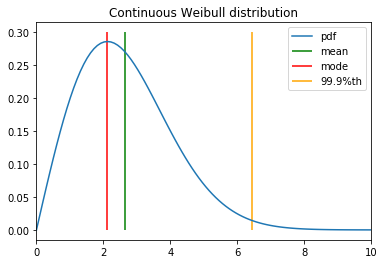

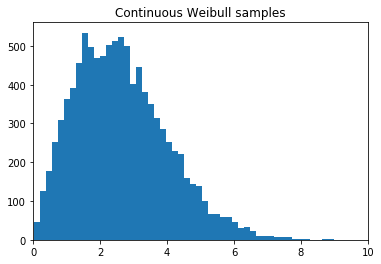

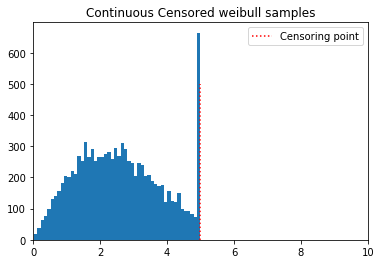

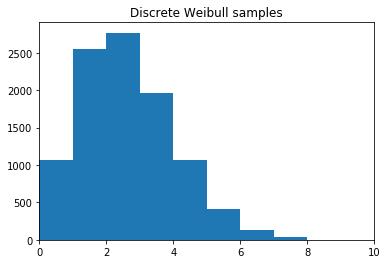

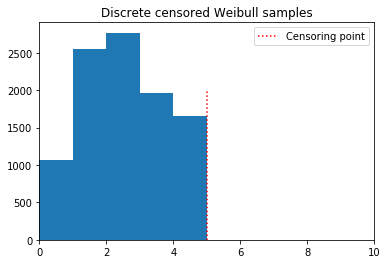

In [2]:
np.random.seed(1)

alpha = 3.
beta  = 2.
# Weibull is a simple distribution. 
y = np.linspace(0,10,100)
# pdf  : (b / a) * np.power(t / a, b - 1) * np.exp(-np.power(t / a, b))
plt.plot(y,wtte.weibull.pdf(t=y,a=alpha,b=beta),label = 'pdf')
# And all the nice 
plt.vlines(x=wtte.weibull.mean(a=alpha,b=beta),ymin=0,ymax=.3,color='green',label = 'mean')
plt.vlines(x=wtte.weibull.mode(a=alpha,b=beta),ymin=0,ymax=.3,color='red',label = 'mode')
plt.vlines(x=wtte.weibull.quantiles(a=alpha,b=beta,p=0.99),ymin=0,ymax=.3,color='orange',label = '99.9%th')
plt.legend()
plt.xlim(0,y.max())
plt.title('Continuous Weibull distribution')
plt.show()

# If we know the params alpha and beta we can easily generate data from it
# quantiles : a * np.power(-np.log(1.0 - p), 1.0 / b)
weibull_samples = wtte.weibull.quantiles(a=alpha,b=beta,p = np.random.uniform(0,1,10000))

plt.hist(weibull_samples,50)
plt.xlim(0,y.max())
plt.title('Continuous Weibull samples')
plt.show()

# We can simulate censored data by simply truncating it
censoring_point = 5.
weibull_samples_censored =  np.minimum(weibull_samples,censoring_point)

plt.hist(weibull_samples_censored,50)
plt.vlines(x=censoring_point,ymin=0,ymax=500,color='red',linestyles='dotted',label = 'Censoring point')
plt.legend()
plt.title('Continuous Censored weibull samples')
plt.xlim(0,y.max())
plt.show()

# And it's even simpler to create discrete data:
weibull_samples_discrete = np.floor(weibull_samples)

plt.hist(weibull_samples_discrete,bins = list(set(weibull_samples_discrete)))
plt.xlim(0,y.max())
plt.title('Discrete Weibull samples')
plt.show()

# Create some discrete censored data for estimation
u = np.less_equal(weibull_samples_discrete, censoring_point)
weibull_samples_discrete_censored =  weibull_samples_discrete
weibull_samples_discrete_censored[~u] = censoring_point

plt.hist(weibull_samples_discrete_censored,bins = list(set(weibull_samples_discrete_censored)))
plt.vlines(x=censoring_point,ymin=0,ymax=2000,color='red',linestyles='dotted',label = 'Censoring point')
plt.legend()
plt.xlim(0,y.max())
plt.title('Discrete censored Weibull samples')
plt.show()

## Estimation - tensorflow

From here we'll focus on the discrete distribution (since continous data are less frequent in the wild).

In [7]:
import tensorflow as tf
from wtte.objectives.tensorflow import loglik_discrete 
# Launch the graph in a session.
sess = tf.Session()
np.random.seed(1)
tf.set_random_seed(1)

y_ = tf.placeholder(tf.float32, shape=(None))
u_ = tf.placeholder(tf.float32, shape=(None))

a = tf.exp(tf.Variable(0.5*tf.ones([1]), name='a_weight'))
b = tf.exp(tf.Variable(0.5*tf.ones([1]), name='b_weight'))

loglik = wtte.objectives.tensorflow.loglik_discrete(a, b, y_, u_)

## ... or inline:
# hazard0 = tf.pow(tf.div(y_ + 1e-35, a), b)
# hazard1 = tf.pow(tf.div(y_ + 1.0, a), b)
# loglik = tf.multiply(u_, tf.log(tf.exp(hazard1 - hazard0) - 1.0)) - hazard1


loss = -tf.reduce_mean(loglik)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

train_step = optimizer.minimize(loss)

# Initializes global variables in the graph.
sess.run(tf.global_variables_initializer())

# Fit
for step in range(1001):
    loss_val, _, a_val, b_val = sess.run([loss, train_step, a, b], 
                                         feed_dict={
                                             y_: weibull_samples_discrete_censored,
                                             u_: u*1.})
    if step%100 ==0:
        print(step,loss_val,'alpha :',a_val,'beta :',b_val)

print('actual | alpha :',alpha,' beta :',beta)
# Should converge to the approximate value that we generated
# Higher alpha leads to higher accuracy.

0 2.27491 alpha : [ 1.64872122] beta : [ 1.64872122]
100 1.72268 alpha : [ 2.77043438] beta : [ 1.70475674]
200 1.70547 alpha : [ 2.93433475] beta : [ 1.9040935]
300 1.70382 alpha : [ 2.96924829] beta : [ 1.97461319]
400 1.70369 alpha : [ 2.97851777] beta : [ 1.99542296]
500 1.7037 alpha : [ 2.98107529] beta : [ 2.00127721]
600 1.7037 alpha : [ 2.98177624] beta : [ 2.00289941]
700 1.7037 alpha : [ 2.98194146] beta : [ 2.00334454]
800 1.70367 alpha : [ 2.98200297] beta : [ 2.00346541]
900 1.70366 alpha : [ 2.98203564] beta : [ 2.00350332]
1000 1.70367 alpha : [ 2.98205662] beta : [ 2.0035181]
actual | alpha : 3.0  beta : 2.0


#### Hint : here $\alpha$ and $\beta$ are just scalars but they might as well be a neural network layer. That's the simple WTTE-RNN trick
